In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Image
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller


In [11]:
def month_string_to_number(string):
    """ month_string_to_number takes a month and turns it into the 
    corresponding number
    args:
        :string - each item is a string

    returns:
        :(out) - the equivalent of the month's number
    """
    m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    s = string.strip()[:3].lower()

    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')
        
path = '/Users/afugere/Desktop/UVM Masters/GraduateSemester2/STAT330/FinalProject/'
path2 = '/Users/abigailhotaling/Documents/STAT_330_Project/Data/'
figpath = '/Users/abigailhotaling/Documents/STAT_330_Project/Figures/'
data = pd.read_csv(path2+ 'Electricity_Residential_Price_New_England.csv')

data.columns = ['Date', 'Electricity Price']
dates = []
months = []
years = []
for entry in data['Date']:
    dates.append(entry.replace('-', ' '))
    data['Month and Year'] = pd.Series(dates)
    months.append(month_string_to_number(str(entry[0:-3])))
    years.append(entry[-2:])
    data['Month'] = pd.Series(months)
    data['Year'] = pd.Series(years)
    
updated_years = []
for y in data['Year']:
    if int(y) > 19:
        updated_years.append('19'+y)
    else:
        updated_years.append('20'+y)
    data['Year'] = pd.Series(updated_years)
    
data['Day'] = [1]*len(data)

data['Datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.iloc[:] = data.iloc[::-1].values

In [12]:
# Seperate the forcasts from US EIA SHORT-TERM ENERGY OUTLOOK 
forcast_eia = data.iloc[-24:]

obs_data = data.iloc[:-24]
# convert to dollar and cents notation
obs_data['Electricity Price'] = obs_data['Electricity Price']/100

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(728610.5, 737047.5)

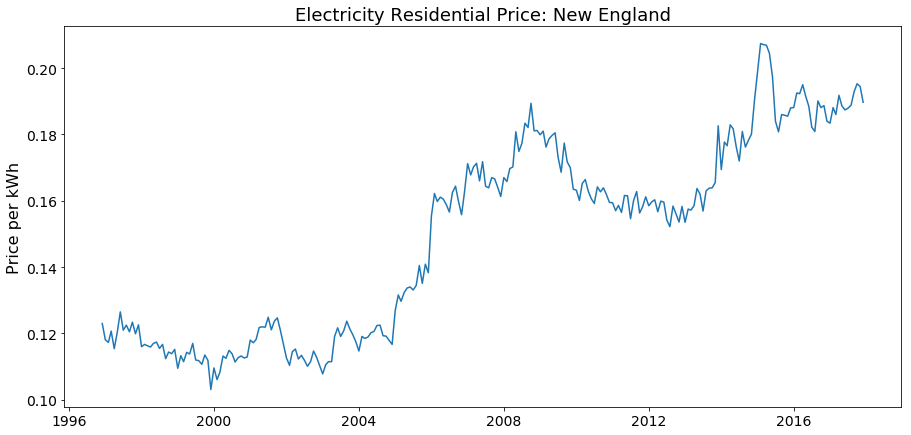

In [30]:
fig, ax = plt.subplots(figsize = (15,7))

ax.plot(obs_data['Datetime'], obs_data['Electricity Price'])
ax.set_title('Electricity Residential Price: New England', fontsize = 18)
ax.set_ylabel('Price per kWh', fontsize = 16)
ax.tick_params(labelsize=14, axis='both')
ax.format_xdata = mdates.DateFormatter('%Y-%m')
limits = ax.get_xlim()
limits
#fig.savefig(figpath+'timeseries.png')

# Seasonal Subseries Plots

In [25]:
groups = obs_data.groupby('Month')
months = pd.concat([pd.DataFrame({name:group['Electricity Price'].values}) 
                    for name, group in groups],
                   ignore_index=True, axis=1)

months.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
overall_mean = months.mean(axis=0)
np.mean(overall_mean)

0.14917454906204905

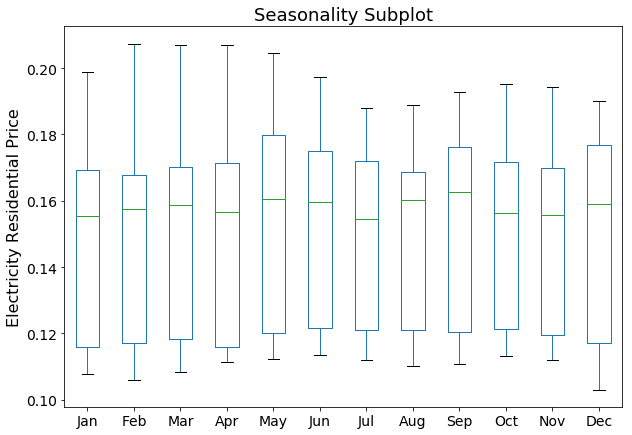

In [15]:
ax = months.boxplot(figsize = (10, 7), grid=False)
fig = ax.get_figure()
ax.set_ylabel('Electricity Residential Price', fontsize=16)
ax.set_title('Seasonality Subplot', fontsize=18)
ax.tick_params(labelsize=14, axis='both')
#ax.plot(overall_mean, color = 'grey', alpha = 0.7)

#fig.savefig(figpath +'seasonality_plot.png')

# Stationarity 

 A stationary series is one in which the properties – mean, variance and covariance, do not vary with time.
 
 Stationarity:
    https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
  

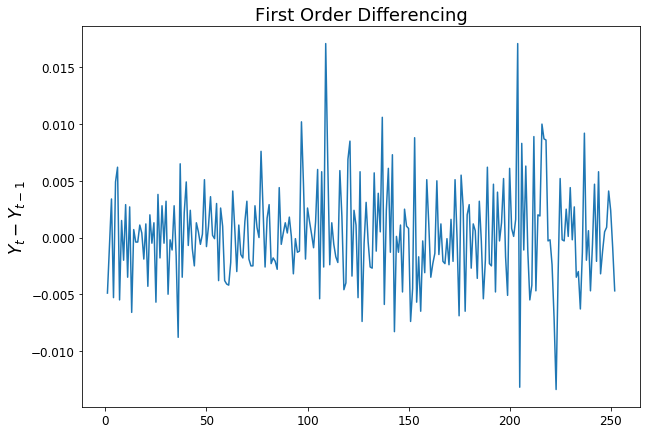

In [16]:
difference = obs_data['Electricity Price'] - obs_data['Electricity Price'].shift(1)
difference.dropna(inplace=True)
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(difference) 
ax.set_ylabel(r'$Y_t-Y_{t-1}$', fontsize = 17)
ax.set_title('First Order Differencing', fontsize = 18)
ax.tick_params(labelsize=12, axis='both')
#fig.savefig(figpath + 'first_order_difference.png')

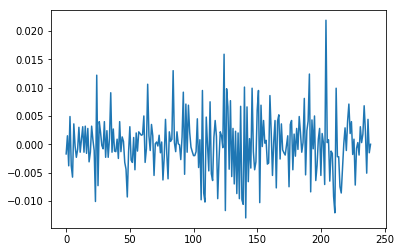

In [39]:
y = list(obs_data['Electricity Price'])
S = 12
z = [y[i]-y[i-1] - (y[i-S]-y[i-S-1]) for i in range(S+1, len(obs_data['Electricity Price']))]
plt.plot(z)



## ADF (Augmented Dickey Fuller) Test

The Dickey Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.



In [40]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(data['Electricity Price'])
# we can conclude that the raw data is unstationary. As we expected!! 

Results of Dickey-Fuller Test:
Test Statistic                  -0.145637
p-value                          0.944699
#Lags Used                       0.000000
Number of Observations Used    276.000000
Critical Value (1%)             -3.454267
Critical Value (5%)             -2.872070
Critical Value (10%)            -2.572381
dtype: float64


The original series is not stationary

In [41]:
# perform the test on the differenced data
print('Differenced Data\n')
adf_test(difference)

Differenced Data

Results of Dickey-Fuller Test:
Test Statistic                  -3.363818
p-value                          0.012256
#Lags Used                      14.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


The differenced series is stationary

# Autocorrelation and Partial Autocorrelation
    
https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

## ACF Plot of first ordered difference

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


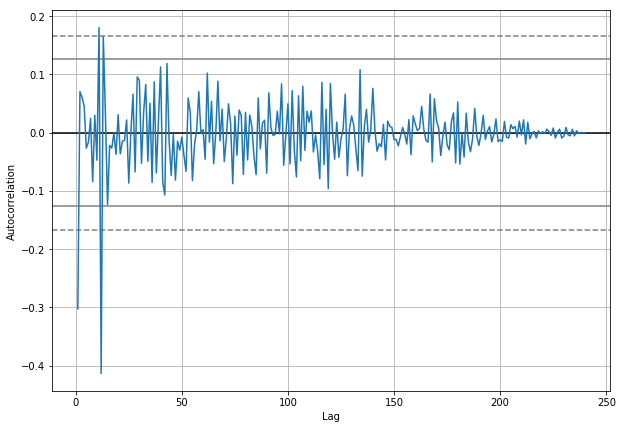

In [52]:
fig, ax  = plt.subplots(figsize = (10,7))
autocorrelation_plot(z, ax = ax)
#ax.set_xlim(0,100)
fig.savefig(figpath + 'autocorrelation.png')

In [45]:
autocorrelation_plot?

## PACF Plot of first ordered difference

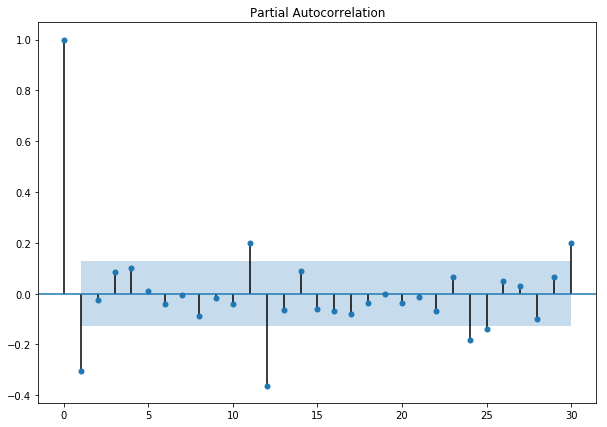

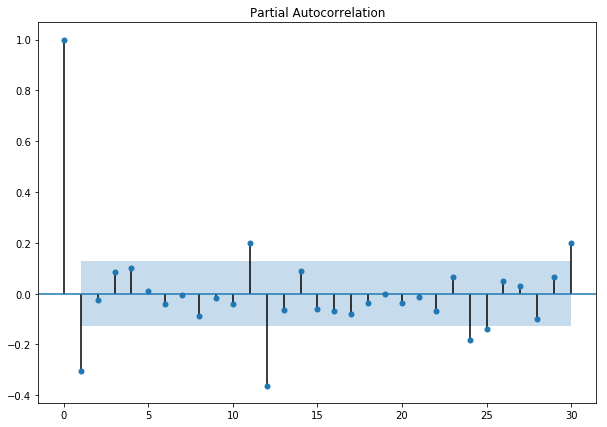

In [49]:
fig, ax = plt.subplots(figsize = (10,7))

plot_pacf(z, lags=30,ax=ax)
#fig.savefig(figpath + 'partial_autocorrelation_difference.png')